<a href="https://colab.research.google.com/github/JisungPark0319/education/blob/main/lab_ml/ml10_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 앙상블 학습 방법(Ensemble Learning)

* 앙상블(ensemble): 기계 학습에서 사용되는 일련의 모델(알고리즘)들.
    * 서로 다른 모델(알고리즘) 여러개를 훈련시키는 방법.
    * 같은 모델(알고리즘)을 서로 다른 훈련 셋에서 훈련시키는 방법.
* 앙상블 학습: 앙상블을 사용한 기계 학습 방법.
    * 투표(voting) 방식: 서로 다른 알고리즘들을 학습시켜서, 각각의 예측값을 투표(다수결) 또는 평균으로 예측하는 방법.
    * Bagging(Bootstrap Aggregating): **중복을 허용해서 샘플링**한 훈련 셋의 부분집합들을 하나의 알고리즘에 학습시켜서 예측(다수결, 평균).
    * Pasting: **중복을 허용하지 않고 샘플링**한 훈련 셋의 부분집합들을 하나의 알고리즘에 학습시켜서 예측.
    * Random Forest: Bagging 방법을 적용한 Decision Tree 앙상블 학습 방법.

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

In [42]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X.shape, y.shape

((500, 2), (500,))

In [43]:
np.unique(y)

array([0, 1])

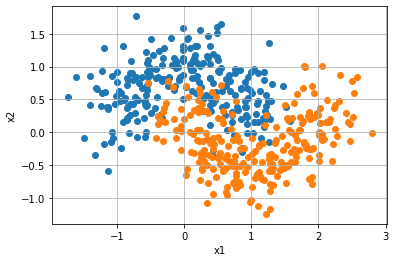

In [44]:
for cls in np.unique(y):
  plt.scatter(X[y == cls, 0], X[y == cls, 1], label='class-{}'.format(cls))

plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

In [45]:
# Train/Test 분리
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 2), (100, 2), (400,), (100,))

* 약한 학습기(weak learner) 여러개를 훈련 셋(X_train, y_Train)으로 훈련
* 각 학습기에서 테스트 셋(X_test, y_test)의 예측값을 계산하고 평가.

In [47]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [48]:
# 학습기(learner) 4개 생성.
log_clf = LogisticRegression(random_state=42)
sgd_clf = SGDClassifier(random_state=42, loss='log')
svm_clf = SVC(random_state=42, probability=True)
forest_clf = RandomForestClassifier(random_state=42, max_depth=3)

In [49]:
classifier = [log_clf, sgd_clf, svm_clf, forest_clf]
for clf in classifier:
  clf.fit(X_train, y_train) # 모델을 훈련 셋으로 학습시킴.
  y_test_pred = clf.predict(X_test) # 훈련된 모델로 테스트 셋의 예측값을 계산.
  acc = accuracy_score(y_test, y_test_pred) # 예측값의 정확도 평가.
  print(clf.__class__.__name__, 'accuracy:', acc)

LogisticRegression accuracy: 0.85
SGDClassifier accuracy: 0.85
SVC accuracy: 0.87
RandomForestClassifier accuracy: 0.87


In [50]:
from sklearn.ensemble import VotingClassifier

* VotingClassifier의 voting 파라미터
    * 기본값='hard', 'soft'를 사용할 수 있음.
    * hard: 다수결 투표. 모든 분류기가 동일하게 1표씩 행사.
    * soft: 각 분류기의 예측값에 그 예측의 확률을 가중치로 곱한 값을 사용해서 예측. 확률이 높은 예측값이 더 높은 가중치를 가지고 투표를 하게되는 방식.
    * 일반적으로 soft voting 방식이 더 좋다고 알려져 있음.
    * soft voting을 사용하려면 모든 분류기가 예측 확률을 계산할 수 있어야 함!
        * SGDClassifier인 경우에는 loss='log'로 지정.
        * SVC인 경우에는 probability=True로 지정.


In [51]:
voting_clf = VotingClassifier(estimators=[('logistic', log_clf),
                                          ('sgd', sgd_clf),
                                          ('svc', svm_clf),
                                          ('rf', forest_clf)],
                              voting='soft',
                              n_jobs=-1)  # 모델 생성

In [52]:
voting_clf.fit(X_train, y_train)  # 모델 훈련

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('sgd',
                              SGDClassifier(alpha=0.0001, average=False,
                                            class_weight=None,
                                            early_st...
                                                     crit

In [53]:
y_test_pred = voting_clf.predict(X_test)  # 예측, 평가
acc = accuracy_score(y_test, y_test_pred)
print('voting ensemble accuracy:', acc)

voting ensemble accuracy: 0.86


## Bagging(Booststrap Aggregating)

In [55]:
from sklearn.tree import DecisionTreeClassifier

In [57]:
# Decision Tree 분류기 1개를 훈련 셋 전체에 대해서 학습. -> 테스트 셋에서 평가.
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_test_pred = tree_clf.predict(X_test)
acc = accuracy_score(y_test, y_test_pred)
acc

0.82

In [58]:
from sklearn.ensemble import BaggingClassifier

In [67]:
bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                                # base_estimator: 기본 추정기(예측기). 머신 러닝 알고리즘(모델).
                                n_estimators=50,  # 추정기의 개수 = 학습 횟수 = 훈련 셋 부분집합 개수
                                max_samples=100,  # 훈련 셋 부분집합이 가질 수 있는 최대 원소 개수.
                                bootstrap=True,   # Ture(중복 허용. Bagging), False(중복 불허. Pasting)
                                n_jobs=-1,        # Multi Task의 개수. (-1=가능한 모든 CPU 코어 사용.)
                                oob_score=True,   # oob(out-of-bagging)
                                random_state=42)

In [68]:
bagging_clf.fit(X_train, y_train) # 모델 훈련

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=42,
  

In [69]:
y_test_pred = bagging_clf.predict(X_test)
acc = accuracy_score(y_test, y_test_pred)
acc

0.92

In [70]:
bagging_clf.oob_score_

0.9175

* OOB(Out-Of-Bagging) 샘플: 학습 셋에서 랜덤하게 부분집합을 만들 때, 한번도 부분집합에 포함되지 않은 샘플들.
* OOB 샘플들을 검증(validation) 데이터로 사용할 수 있음.
* BaggingClassifier/Regressor의 파라미터 oob_score=True로 지정하면, 학습 후에 OOB 샘플들로 계산된 점수(정확도, MSE)를 얻을 수 있음.
* oob_score_는 테스트 셋의 점수를 추정할 수 있음.

## Random Forest 분류기
Decision Tree를 추정기(estimator)로 사용하는 Bagging 앙상블 학습 방법.

In [71]:
from sklearn.ensemble import RandomForestClassifier

In [74]:
forest_clf = RandomForestClassifier(n_estimators=50, bootstrap=True, oob_score=True,
                                    n_jobs=-1, random_state=42, max_samples=100)
forest_clf.fit(X_train, y_train)
print('oob score:', forest_clf.oob_score_)

y_test_pred = forest_clf.predict(X_test)
acc = accuracy_score(y_test, y_test_pred)
print('test acc:', acc)

oob score: 0.9125
test acc: 0.93


Random Forest의 장점 중 하나는 특성(변수)들의 중요도를 자동으로 측정해 준다는 점.

In [75]:
from sklearn.datasets import load_iris

In [76]:
iris = load_iris()
X, y = iris['data'], iris['target']

In [77]:
forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
forest_clf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [79]:
forest_clf.feature_importances_
#> 3, 4번째(column index 2, 3번) 특성들이 다른 특성들에 비해서 더 중요!

array([0.10612762, 0.02167809, 0.43612951, 0.43606478])